# Download the dataset

In [1]:
!pip install opendatasets


[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import opendatasets as op
op.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

Skipping, found downloaded files in ".\chest-xray-pneumonia" (use force=True to force download)


In [1]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

In [3]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [4]:
readDatasetObject = ReadDataset('chest-xray-pneumonia/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [6]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

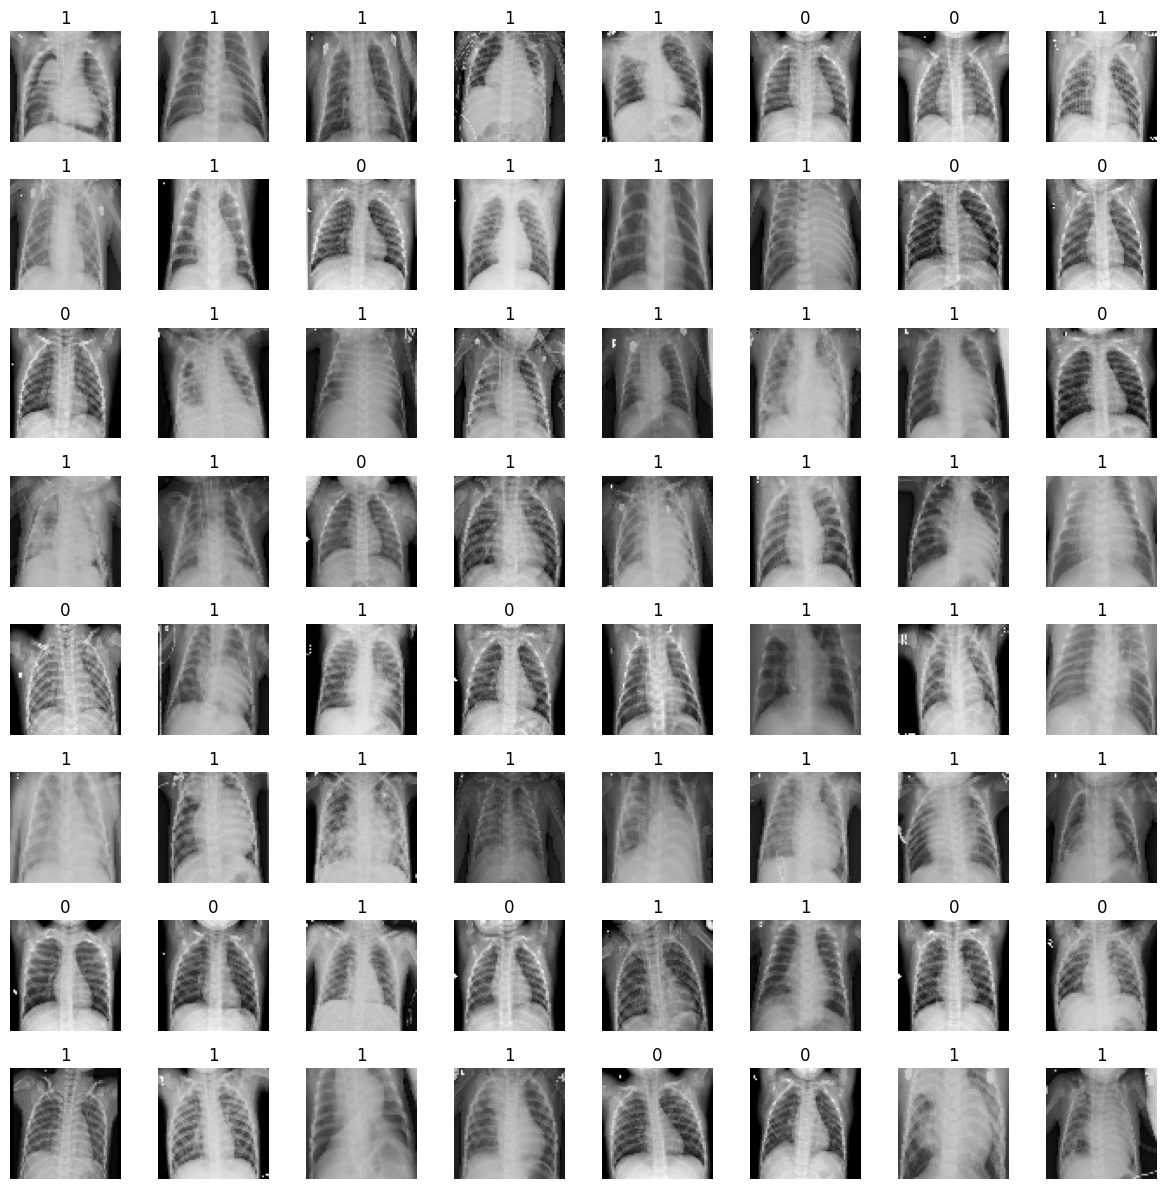

In [7]:
plt.figure(figsize=(12, 12))
indexs = np.random.randint(0, len(labels), size=(64,))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
    plt.axis('off')  # Turn off axis to make it cleaner
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [36]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [37]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 30001, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [38]:
acgan.data(images, labels)

In [39]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 32, 32, 32)           2432      ['input_20[0][0]']            
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)  (None, 32, 32, 32)           0         ['conv2d_24[0][0]']           
                                                                                                  
 conv2d_25 (Conv2D)          (None, 16, 16, 64)           51264     ['leaky_re_lu_24[0][0]']      
                                                                                      

In [12]:
tf.keras.utils.plot_model(GAN, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
tf.keras.utils.plot_model(G, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
tf.keras.utils.plot_model(D, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Epoch: 0
discriminator loss: [tag: 0.5123780965805054, labels: 0.6973922252655029], generator loss: [tag: 0.7550411224365234, labels: 0.6922342777252197]
1/1 [==============================] - 0s 164ms/step


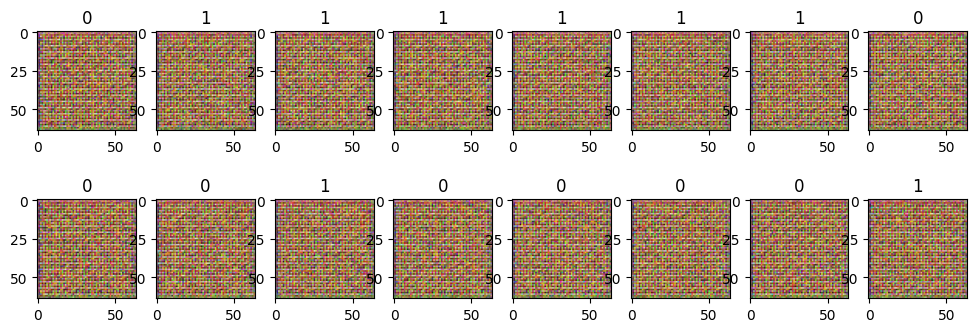

Epoch: 5000
discriminator loss: [tag: 0.2529236376285553, labels: 0.005099920555949211], generator loss: [tag: 0.28132063150405884, labels: 0.005071053747087717]
1/1 [==============================] - 0s 221ms/step


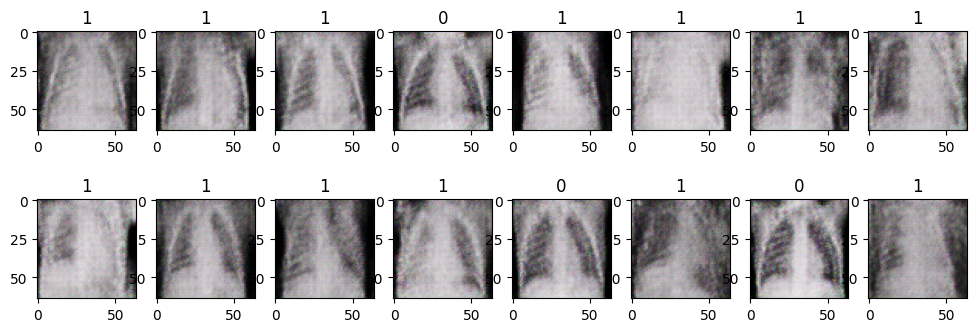

Epoch: 10000
discriminator loss: [tag: 0.24395713210105896, labels: 0.010421999730169773], generator loss: [tag: 0.2522375285625458, labels: 0.00032000249484553933]
1/1 [==============================] - 0s 181ms/step


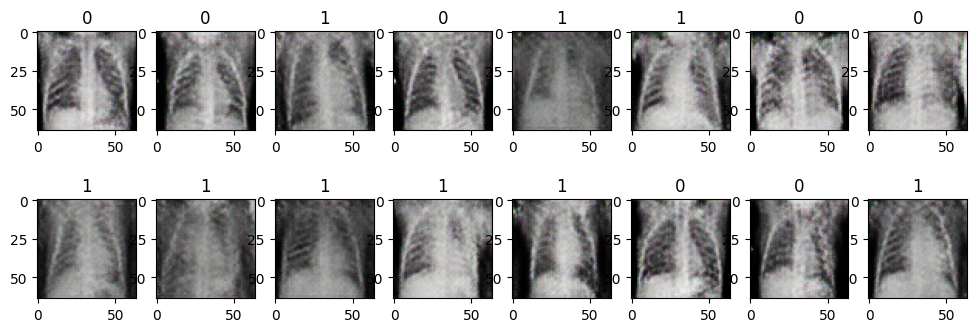

Epoch: 15000
discriminator loss: [tag: 0.23140853643417358, labels: 0.013654252514243126], generator loss: [tag: 0.3272705674171448, labels: 0.0007989374571479857]
1/1 [==============================] - 0s 205ms/step


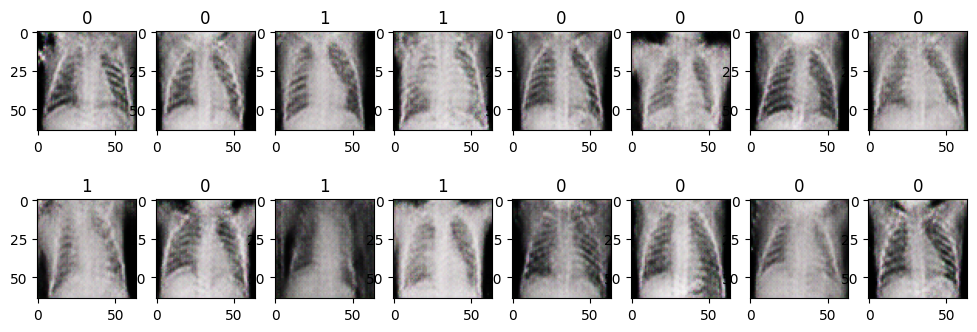

Epoch: 20000
discriminator loss: [tag: 0.22064290940761566, labels: 0.0018067874480038881], generator loss: [tag: 0.4136996269226074, labels: 0.002398528391495347]
1/1 [==============================] - 0s 183ms/step


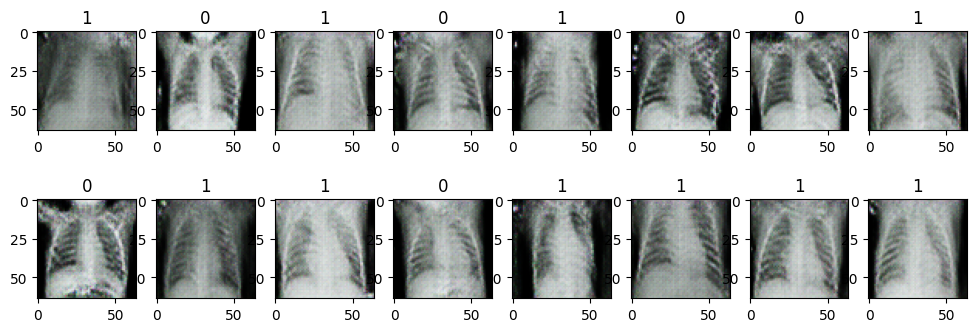

Epoch: 25000
discriminator loss: [tag: 0.20580175518989563, labels: 0.007549369242042303], generator loss: [tag: 0.33009862899780273, labels: 0.00011266015644650906]
1/1 [==============================] - 0s 176ms/step


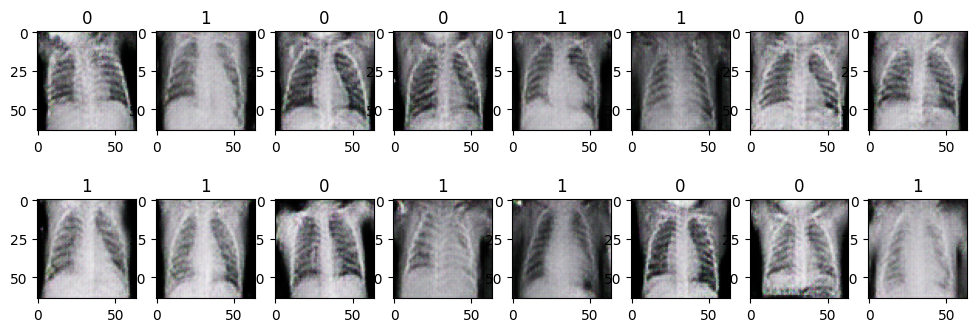

Epoch: 30000
discriminator loss: [tag: 0.19831812381744385, labels: 0.0003903309116140008], generator loss: [tag: 0.3212878108024597, labels: 0.004013645462691784]
1/1 [==============================] - 0s 218ms/step


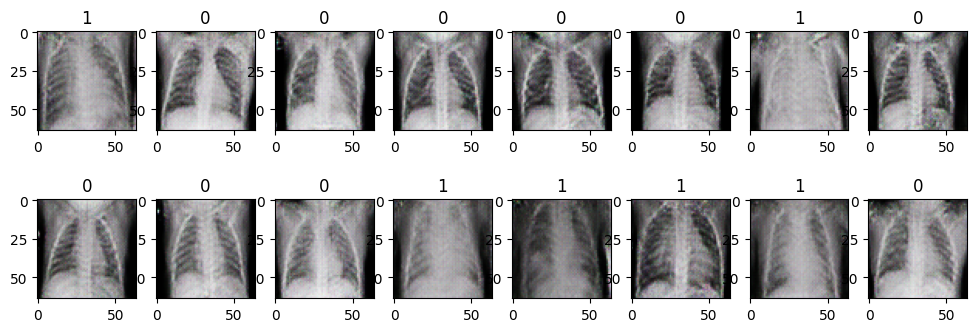

In [40]:
acgan.trainAlgorithm(G, D, GAN)

In [41]:
G.save('generator.h5')

c:\Users\Wallow\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
G = tf.keras.models.load_model('generator.h5')

In [43]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [44]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [45]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1], dtype=int64), array([15118, 14882], dtype=int64))

In [46]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 188s 200ms/step


(30000, 64, 64, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


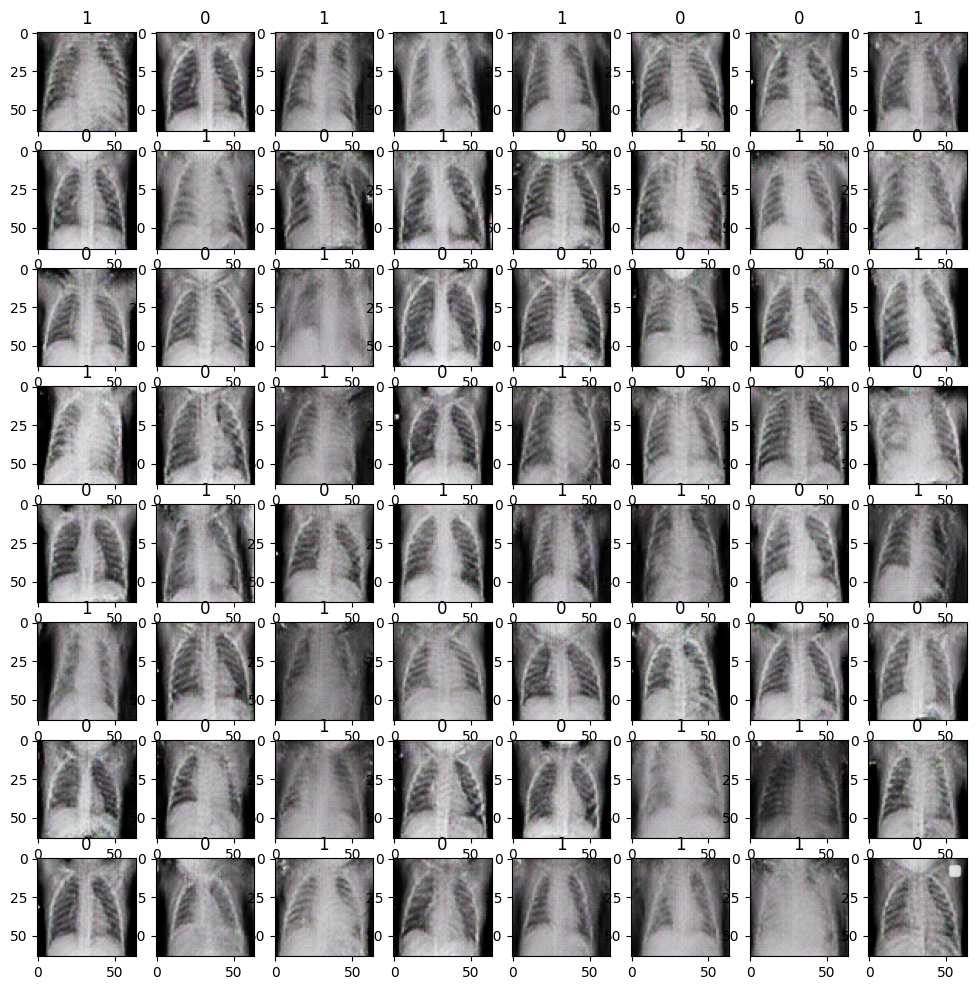

In [47]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In [48]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()
#make the summary a figure
tf.keras.utils.plot_model(m, show_shapes = True)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [49]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 618s 2s/step - loss: 0.2399 - val_loss: 0.5613
Epoch 2/60
375/375 [==============================] - 584s 2s/step - loss: 0.0739 - val_loss: 0.0567
Epoch 3/60
375/375 [==============================] - 535s 1s/step - loss: 0.0521 - val_loss: 0.0208
Epoch 4/60
375/375 [==============================] - 528s 1s/step - loss: 0.0413 - val_loss: 0.0188
Epoch 5/60
375/375 [==============================] - 524s 1s/step - loss: 0.0363 - val_loss: 0.0149
Epoch 6/60
375/375 [==============================] - 526s 1s/step - loss: 0.0312 - val_loss: 0.0138
Epoch 7/60
375/375 [==============================] - 526s 1s/step - loss: 0.0291 - val_loss: 0.0128
Epoch 8/60
375/375 [==============================] - 526s 1s/step - loss: 0.0256 - val_loss: 0.0127
Epoch 9/60
375/375 [==============================] - 529s 1s/step - loss: 0.0225 - val_loss: 0.0096
Epoch 10/60
375/375 [==============================] - 530s 1s/step - loss: 0.0211 - val_lo

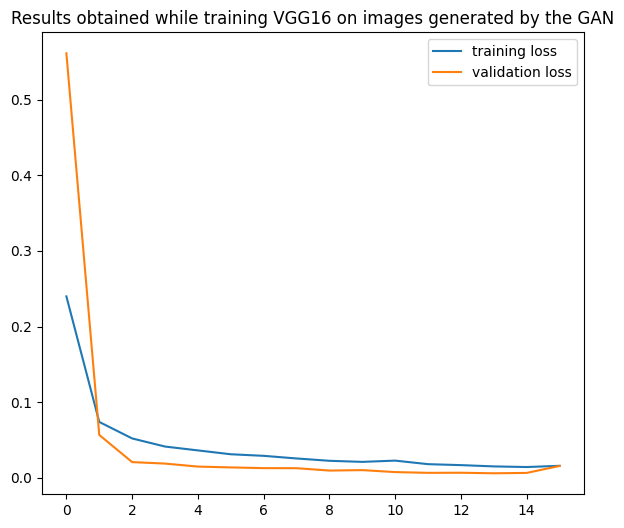

In [50]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training VGG16 on images generated by the GAN')
plt.legend()

In [51]:
m.evaluate(images, labels)

163/163 [==============================] - 32s 197ms/step - loss: 0.3075


0.307548463344574

In [52]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 37s 223ms/step


TensorShape([5216])

In [53]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [55]:
accuracy_score(y_pred, labels)*100

90.06901840490798

In [56]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1843
           1       0.87      1.00      0.93      3373

    accuracy                           0.90      5216
   macro avg       0.93      0.86      0.88      5216
weighted avg       0.91      0.90      0.90      5216



In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1333,  510],
       [   8, 3365]], dtype=int64)

In [58]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL       1333        510
PNEUMONIA       8       3365

In [59]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 92.85320088300222, recall_score: 99.76282241328195, precision_score: 86.83870967741936


<Axes: >

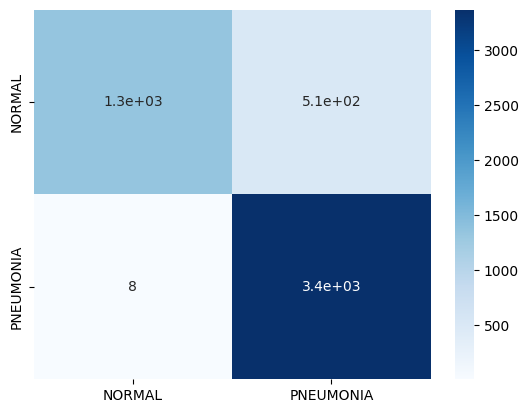

In [60]:
sns.heatmap(cmObject, annot = True, cmap="Blues")